In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install tensorflow -q

In [6]:
import os
import numpy as np
import librosa
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

In [8]:
# Paths
audio_dir = '/content/drive/MyDrive/sampless'
# os.makedirs(output_dir, exist_ok=True)

# Parameters
sr = 44100
n_fft = 2048
hop_length = 512
n_mfcc = 13
chunk_size_sec = 0.3  # 0.2-second chunks
chunk_frames = int(chunk_size_sec * sr / hop_length)  # ~43 frames
overlap_ratio = 0.2  # 20% overlap
overlap_frames = int(overlap_ratio * chunk_frames)  # 20% of chunk_frames
step_size = chunk_frames - overlap_frames  # Step size for 20% overlap

# Fault types
fault_types = {'Arcing': 0, 'Corona': 1, 'Looseness': 2, 'Tracking': 3}

In [9]:
data = []
labels = []

# Process audio files with overlap
for audio_file in os.listdir(audio_dir):
    if audio_file.endswith('.wav'):
        filepath = os.path.join(audio_dir, audio_file)
        audio, _ = librosa.load(filepath, sr=sr)

        # MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        # STFT (magnitude and phase)
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        stft_mag = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        stft_phase = np.angle(stft)

        # Segment into 0.2-second chunks with 20% overlap
        for start in range(0, mfcc.shape[1] - chunk_frames + 1, step_size):
            end = start + chunk_frames
            mfcc_chunk = mfcc[:, start:end]
            mag_chunk = stft_mag[:n_mfcc, start:end]  # Crop to match MFCC
            phase_chunk = stft_phase[:n_mfcc, start:end]

            # Pad if the chunk is too short (e.g., at the end of the audio)
            if mfcc_chunk.shape[1] < chunk_frames:
                mfcc_chunk = np.pad(mfcc_chunk, ((0, 0), (0, chunk_frames - mfcc_chunk.shape[1])), mode='constant')
                mag_chunk = np.pad(mag_chunk, ((0, 0), (0, chunk_frames - mag_chunk.shape[1])), mode='constant')
                phase_chunk = np.pad(phase_chunk, ((0, 0), (0, chunk_frames - phase_chunk.shape[1])), mode='constant')

            chunk = np.stack((mfcc_chunk, mag_chunk, phase_chunk), axis=-1)
            data.append(chunk)
            for fault in fault_types:
                if fault in audio_file:
                    labels.append(fault_types[fault])
                    break

In [10]:
for audio_file in os.listdir(audio_dir):
    if audio_file.endswith('.wav'):
        filepath = os.path.join(audio_dir, audio_file)
        audio, _ = librosa.load(filepath, sr=sr)

        augmentations = [
            librosa.effects.time_stretch(audio, rate=0.9),
            librosa.effects.time_stretch(audio, rate=1.1),
            librosa.effects.pitch_shift(audio, sr=sr, n_steps=2),
            librosa.effects.pitch_shift(audio, sr=sr, n_steps=-2),
            audio + 0.005 * np.random.randn(len(audio))
        ]

        for aug_audio in augmentations:
            mfcc_aug = librosa.feature.mfcc(y=aug_audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            stft_aug = librosa.stft(aug_audio, n_fft=n_fft, hop_length=hop_length)
            stft_mag_aug = librosa.amplitude_to_db(np.abs(stft_aug), ref=np.max)
            stft_phase_aug = np.angle(stft_aug)

            for start in range(0, mfcc_aug.shape[1], chunk_frames):
                mfcc_chunk = mfcc_aug[:, start:start + chunk_frames]
                mag_chunk = stft_mag_aug[:n_mfcc, start:start + chunk_frames]
                phase_chunk = stft_phase_aug[:n_mfcc, start:start + chunk_frames]

                if mfcc_chunk.shape[1] < chunk_frames:
                    mfcc_chunk = np.pad(mfcc_chunk, ((0, 0), (0, chunk_frames - mfcc_chunk.shape[1])), mode='constant')
                    mag_chunk = np.pad(mag_chunk, ((0, 0), (0, chunk_frames - mag_chunk.shape[1])), mode='constant')
                    phase_chunk = np.pad(phase_chunk, ((0, 0), (0, chunk_frames - phase_chunk.shape[1])), mode='constant')

                chunk = np.stack((mfcc_chunk, mag_chunk, phase_chunk), axis=-1)
                data.append(chunk)
                for fault in fault_types:
                    if fault in audio_file:
                        labels.append(fault_types[fault])
                        break

In [11]:
from scipy.ndimage import zoom
import gc

In [12]:

data = np.array(data)  # Shape: [7435, 13, 43, 3]
labels = np.array(labels)

# Print shapes to confirm
print(f"Data shape: {data.shape}")
print(f"First sample shape: {data[0].shape}")

# Normalize each channel
for channel in range(3):
    data[:, :, :, channel] = (data[:, :, :, channel] - np.mean(data[:, :, :, channel])) / np.std(data[:, :, :, channel])

# Transform rectangular [13, 43, 3] to square [34, 34, 3] using interpolation
num_samples = data.shape[0]
original_height, original_width = data.shape[1], data.shape[2]  # 13, 43
new_size = 34
print(f"Target square size: {new_size}")
square_data = np.zeros((num_samples, new_size, new_size, 3), dtype=np.float32)  # [7435, 34, 34, 3]

# Calculate zoom factors
zoom_factor_height = new_size / original_height  # 34 / 13 ≈ 2.615
zoom_factor_width = new_size / original_width    # 34 / 43 ≈ 0.791

for i in range(num_samples):
    for channel in range(3):
        img = data[i, :, :, channel]  # [13, 43]
        # Resize using interpolation (bicubic by default in scipy.ndimage.zoom)
        resized = zoom(img, (zoom_factor_height, zoom_factor_width), order=3)  # [34, 34]
        square_data[i, :, :, channel] = resized




Data shape: (19247, 13, 17, 3)
First sample shape: (13, 17, 3)
Target square size: 34


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(square_data, labels, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")



Training samples: 15397, Test samples: 3850
X_train shape: (15397, 34, 34, 3), X_test shape: (3850, 34, 34, 3)


In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(34, 34, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,492 (1.92 MB)

 Trainable params: 503,492 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.4527 - loss: 1.1852 - val_accuracy: 0.6483 - val_loss: 0.8429
Epoch 2/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.6483 - loss: 0.8408 - val_accuracy: 0.7494 - val_loss: 0.5751
Epoch 3/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7576 - loss: 0.5905 - val_accuracy: 0.8034 - val_loss: 0.4852
Epoch 4/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7899 - loss: 0.5062 - val_accuracy: 0.8216 - val_loss: 0.4201
Epoch 5/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.8113 - loss: 0.4590 - val_accuracy: 0.8223 - val_loss: 0.4434
Epoch 6/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.8270 - loss: 0.4178 - val_accuracy: 0.8361 - val_loss: 0.3860
Epoch 7/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.8356 - loss: 0.4042 - val_accuracy: 0.8457 - val_loss: 0.3604
Epoch 8/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.8446 - loss: 0.3734 - 

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
model.save('fault_detection.h5')

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8764 - loss: 0.3774


Test Accuracy: 0.8792


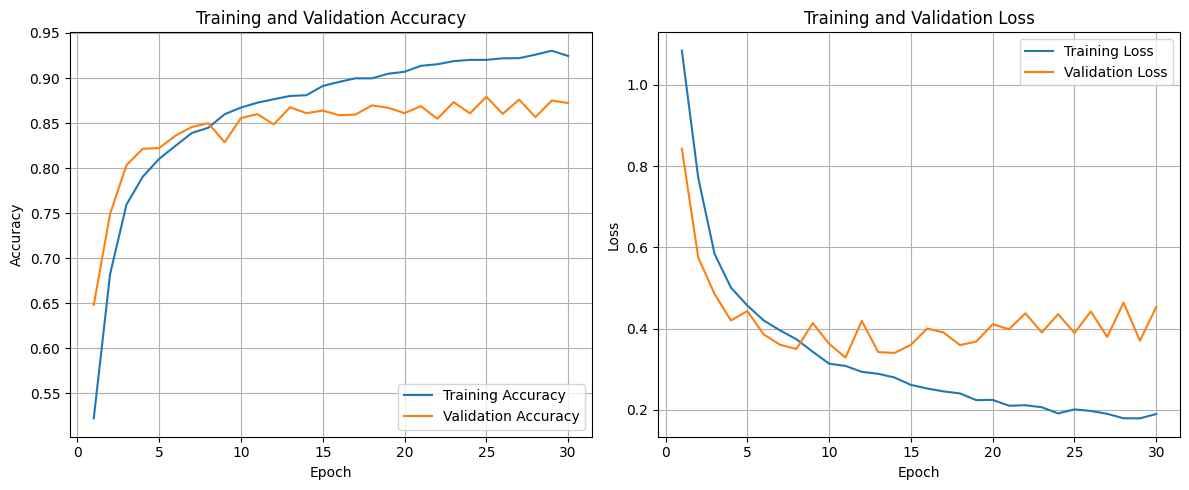

In [19]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Evaluate the model on the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [28]:
fault_types_reverse = {v: k for k, v in fault_types.items()}

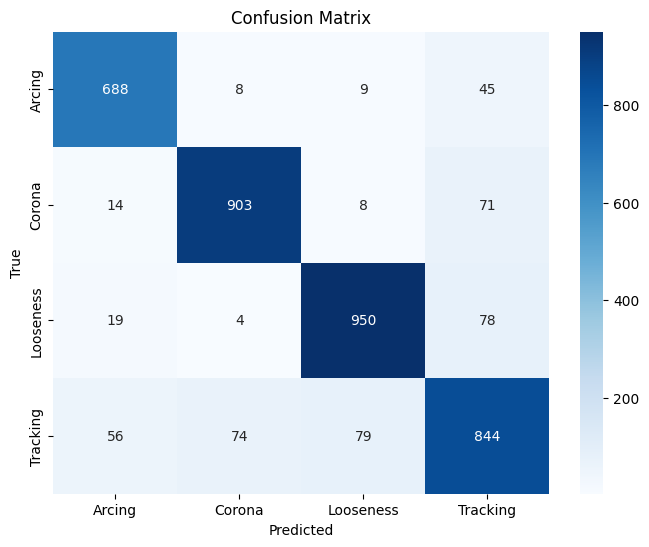

In [29]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=fault_types_reverse.values(),
            yticklabels=fault_types_reverse.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
# Compute and display other evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=fault_types_reverse.values()))

# Compute overall metrics
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

      Arcing       0.89      0.92      0.90       750
      Corona       0.91      0.91      0.91       996
   Looseness       0.91      0.90      0.91      1051
    Tracking       0.81      0.80      0.81      1053

    accuracy                           0.88      3850
   macro avg       0.88      0.88      0.88      3850
weighted avg       0.88      0.88      0.88      3850


Validation Loss: 0.3894
Validation Accuracy: 0.8792


**Test on new data**

In [33]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
from collections import Counter
import gc

# Paths
new_audio_dir = '/content/drive/MyDrive/new_test_data'  # Directory for new test data
model_path = 'fault_detection.h5'  # Path to the saved CNN model (update if different)

new_size = 34  # Target size for the CNN

# Fault types (same as training)
fault_types = {0: 'Arcing', 1: 'Corona', 2: 'Looseness', 3: 'Tracking'}

# Load new test data
new_data = []
filenames = []

for audio_file in os.listdir(new_audio_dir):
    if audio_file.endswith('.wav'):
        filepath = os.path.join(new_audio_dir, audio_file)
        audio, _ = librosa.load(filepath, sr=sr)

        # MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        # STFT (magnitude and phase)
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        stft_mag = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        stft_phase = np.angle(stft)

        # Segment into 0.5-second chunks with 20% overlap
        for start in range(0, mfcc.shape[1] - chunk_frames + 1, step_size):
            end = start + chunk_frames
            mfcc_chunk = mfcc[:, start:end]
            mag_chunk = stft_mag[:n_mfcc, start:end]  # Crop to match MFCC
            phase_chunk = stft_phase[:n_mfcc, start:end]

            # Pad if the chunk is too short
            if mfcc_chunk.shape[1] < chunk_frames:
                mfcc_chunk = np.pad(mfcc_chunk, ((0, 0), (0, chunk_frames - mfcc_chunk.shape[1])), mode='constant')
                mag_chunk = np.pad(mag_chunk, ((0, 0), (0, chunk_frames - mag_chunk.shape[1])), mode='constant')
                phase_chunk = np.pad(phase_chunk, ((0, 0), (0, chunk_frames - phase_chunk.shape[1])), mode='constant')

            chunk = np.stack((mfcc_chunk, mag_chunk, phase_chunk), axis=-1)
            new_data.append(chunk)
            filenames.append(audio_file)

# Convert to NumPy array
new_data = np.array(new_data)
print(f"Processed {len(new_data)} chunks.")

# Normalize each channel (same as training)
for channel in range(3):
    new_data[:, :, :, channel] = (new_data[:, :, :, channel] - np.mean(new_data[:, :, :, channel])) / np.std(new_data[:, :, :, channel])

# Transform rectangular [13, 43, 3] to square [34, 34, 3] using interpolation
num_samples = new_data.shape[0]
original_height, original_width = new_data.shape[1], new_data.shape[2]  # 13, 43
square_new_data = np.zeros((num_samples, new_size, new_size, 3), dtype=np.float32)  # [num_samples, 34, 34, 3]

# Calculate zoom factors
zoom_factor_height = new_size / original_height  # 34 / 13 ≈ 2.615
zoom_factor_width = new_size / original_width    # 34 / 43 ≈ 0.791

for i in range(num_samples):
    for channel in range(3):
        img = new_data[i, :, :, channel]  # [13, 43]
        # Resize using interpolation (bicubic)
        resized = zoom(img, (zoom_factor_height, zoom_factor_width), order=3)  # [34, 34]
        square_new_data[i, :, :, channel] = resized



Processed 399 chunks.


In [34]:
# Make predictions
predictions = model.predict(square_new_data, batch_size=16)
predicted_classes = np.argmax(predictions, axis=1)
# Convert NumPy integers to Python integers
predicted_faults = [fault_types[int(pred)] for pred in predicted_classes]

# Print per-chunk predictions
for i, (filename, fault) in enumerate(zip(filenames, predicted_faults)):
    chunks_per_file = len([f for f in filenames if f == filename])
    chunk_num = (i % chunks_per_file) + 1
    print(f"File: {filename}, Chunk {chunk_num}: Predicted Fault = {fault}")

# Aggregate predictions per file
file_predictions = {}
for filename, fault in zip(filenames, predicted_faults):
    if filename not in file_predictions:
        file_predictions[filename] = []
    file_predictions[filename].append(fault)

for filename, faults in file_predictions.items():
    most_common_fault = Counter(faults).most_common(1)[0][0]
    print(f"File: {filename}, Overall Predicted Fault = {most_common_fault}")

# Clean up
del new_data, square_new_data
gc.collect()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
File: Arcing (1).wav, Chunk 1: Predicted Fault = Corona
File: Arcing (1).wav, Chunk 2: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 3: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 4: Predicted Fault = Tracking
File: Arcing (1).wav, Chunk 5: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 6: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 7: Predicted Fault = Tracking
File: Arcing (1).wav, Chunk 8: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 9: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 10: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 11: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 12: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 13: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 14: Predicted Fault = Arcing
File: Arcing (1).wav, Chunk 15: Predicted Fault = Looseness
File: Arcing (1).wav, Chunk 16: Predicted Fault = Tracking
File: Arcing (1).wav, Chunk 17: Predicted Fault =

5925